# Last Words of Death Row Inmates - NLP Analysis

[dataset](https://www.kaggle.com/datasets/mykhe1097/last-words-of-death-row-inmates)

## Install Libraries

In [ ]:
!pip3 install stop_words 
!pip3 install textstat 
!pip3 install transformers

  Created wheel for stop-words: filename=stop_words-2018.7.23-py3-none-any.whl size=32911 sha256=3f6c3d179ab4228bb251f53436a92839e4606195578a048b2adc37a9733de182
  Stored in directory: /root/.cache/pip/wheels/fb/86/b2/277b10b1ce9f73ce15059bf6975d4547cc4ec3feeb651978e9
Successfully built stop-words
     |████████████████████████████████| 101 kB 3.9 MB/s 
     |████████████████████████████████| 2.0 MB 18.6 MB/s 
     |████████████████████████████████| 3.5 MB 5.4 MB/s 
     |████████████████████████████████| 895 kB 39.1 MB/s 
     |████████████████████████████████| 596 kB 43.0 MB/s 
     |████████████████████████████████| 6.5 MB 30.1 MB/s 
     |████████████████████████████████| 67 kB 4.9 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
!pip3 install -U -q PyDrive

### Import Libraries

In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [ ]:
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
!pip3 install textblob

In [ ]:
!pip3 install afinn

     |████████████████████████████████| 52 kB 1.0 MB/s 
  Created wheel for afinn: filename=afinn-0.1-py3-none-any.whl size=53447 sha256=7c0da64499bad226c0e117e0b0ae3affed60fd4b0ce3a06b09cf191739d03994
  Stored in directory: /root/.cache/pip/wheels/9d/16/3a/9f0953027434eab5dadf3f33ab3298fa95afa8292fcf7aba75
Successfully built afinn


In [ ]:
#load libraries
import pandas as pd
import numpy as np
import re
import string
from string import punctuation
import nltk
from nltk.text import Text
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.draw.dispersion import dispersion_plot
nltk.download('punkt')
from stop_words import get_stop_words
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
import spacy
import matplotlib.pyplot as plt 
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
import seaborn as sns
from collections import Counter
import textstat
from nltk.tokenize.treebank import TreebankWordDetokenizer
from transformers import pipeline
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from google.colab import drive
import textblob
from afinn import Afinn

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv("drive/My Drive/NLP/NLP Assignment 2/death_row.csv", encoding = 'latin1')
df.index = df.index.map(str)
df.head(5)

,Execution,LastName,FirstName,TDCJNumber,Age,Race,CountyOfConviction,AgeWhenReceived,EducationLevel,NativeCounty,PreviousCrime,Codefendants,NumberVictim,WhiteVictim,HispanicVictim,BlackVictim,VictimOther Races,FemaleVictim,MaleVictim,LastStatement
0,545,Cardenas,Ruben,999275,47,Hispanic,Hidalgo,28.0,11.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,"This is my statement: My final words. First, I..."
1,544,Pruett,Robert,999411,38,White,Bee,22.0,8.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,I just want to let everyone in here to know I ...
2,543,Preyor,Taichin,999494,46,Black,Bexar,34.0,10.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,"First and foremost I'd like to say, ""Justice h..."
3,542,Bigby,James,997,61,White,Tarrant,36.0,9.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,"Yes, I do, Grace Kehler is that you? I have gi..."
4,541,Ruiz,Rolando,999145,44,Hispanic,Bexar,22.0,10.0,0.0,1.0,4.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,"Yes sir, I would first like to say to the Sanc..."


## Preprocessing

**remove rows with 'None' as nothing was recorded for that individual**

In [ ]:
df = df[(df['LastStatement']!='None')]

**We must apply a regex function to remove the parentheses and the content within as it describes the form it was collected (ie written or spoken), language (ie: (Spanish), (French), etc)), and the people the statement was directed to (ie: (To the Family), etc))**

In [ ]:
df['LastStatement'] = df['LastStatement'].apply(lambda x: re.sub(r"\([^()]*\)", "", x))
df['LastStatement'].head(5)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


0    This is my statement: My final words. First, I...
1    I just want to let everyone in here to know I ...
2    First and foremost I'd like to say, "Justice h...
3    Yes, I do, Grace Kehler is that you? I have gi...
4    Yes sir, I would first like to say to the Sanc...
Name: LastStatement, dtype: object

**Make all strings lowercase**

In [ ]:
df['LastStatement'] = df['LastStatement'].str.lower()
df['LastStatement'].head(5)

0    this is my statement: my final words. first, i...
1    i just want to let everyone in here to know i ...
2    first and foremost i'd like to say, "justice h...
3    yes, i do, grace kehler is that you? i have gi...
4    yes sir, i would first like to say to the sanc...
Name: LastStatement, dtype: object

**Remove all punctuation**

In [ ]:
punc = punctuation.replace(",", "")
df['LastStatement'] = df['LastStatement'].apply(lambda x: x.translate(str.maketrans("", "", punc)))

df['LastStatement'].head(5)

0    this is my statement my final words first, i w...
1    i just want to let everyone in here to know i ...
2    first and foremost id like to say, justice has...
3    yes, i do, grace kehler is that you i have giv...
4    yes sir, i would first like to say to the sanc...
Name: LastStatement, dtype: object

In [ ]:
nltk.download('stopwords')
stopwords = stopwords.words('english')
stopwords.append('final')
stopwords.append('word')
stopwords.append('words')
stopwords.append('statement')
stopwords.append('say')
stopwords.append('sentence')
stopwords.append('till')
df['LastStatement_cleaned'] = df['LastStatement'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stopwords)]))
df.LastStatement_cleaned

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


0      first, want thank family believing end love mu...
1      want let everyone know love much ive hurt lot ...
2      first foremost id like say, justice never adva...
3      yes, do, grace kehler given warden jones writt...
4      yes sir, would first like sanchez family sorry...
                             ...                        
539    heavenly father, give thanks time, time togeth...
540                   pray family rejoice forgive, thank
541    asked last statement, replied, yes, doi hope o...
542    transpire moments wrong however, human beings ...
544    media i, moment, absolutely fear may happen bo...
Name: LastStatement_cleaned, Length: 431, dtype: object

In [ ]:
my_punctuation = punctuation.replace("'", "")

In [ ]:
punc = punctuation.replace("'", "")

df['LastStatement_cleaned'] = df['LastStatement_cleaned'].apply(lambda x: x.translate(str.maketrans("", "", punc)))

df['LastStatement_cleaned'] 

0      first want thank family believing end love muc...
1      want let everyone know love much ive hurt lot ...
2      first foremost id like say justice never advan...
3      yes do grace kehler given warden jones written...
4      yes sir would first like sanchez family sorry ...
                             ...                        
539    heavenly father give thanks time time together...
540                    pray family rejoice forgive thank
541    asked last statement replied yes doi hope one ...
542    transpire moments wrong however human beings m...
544    media i moment absolutely fear may happen body...
Name: LastStatement_cleaned, Length: 431, dtype: object

***Tokenize!***

In [ ]:
df['tokenized'] = df.apply(lambda row: nltk.word_tokenize(row['LastStatement_cleaned']), axis = 1)
df.tokenized


0      [first, want, thank, family, believing, end, l...
1      [want, let, everyone, know, love, much, ive, h...
2      [first, foremost, id, like, say, justice, neve...
3      [yes, do, grace, kehler, given, warden, jones,...
4      [yes, sir, would, first, like, sanchez, family...
                             ...                        
539    [heavenly, father, give, thanks, time, time, t...
540              [pray, family, rejoice, forgive, thank]
541    [asked, last, statement, replied, yes, doi, ho...
542    [transpire, moments, wrong, however, human, be...
544    [media, i, moment, absolutely, fear, may, happ...
Name: tokenized, Length: 431, dtype: object

##  Transforming documents into numbers

In [ ]:
vect = CountVectorizer()

#CountVectorizer.vect_transform() does not accept lists, so join the tokens into one string
df['tokenized_unlisted'] = df['tokenized'].apply(lambda x: ' '.join(x))


vects = vect.fit_transform(df.tokenized_unlisted)

td = pd.DataFrame(vects.todense())
td.columns = vect.get_feature_names()
term_document_matrix = td.T
term_document_matrix.columns = ['Doc '+str(i) for i in range(0, len(df.tokenized_unlisted))]
term_document_matrix['total_count'] = term_document_matrix.sum(axis = 1)

#top 25 words
term_document_matrix = term_document_matrix.sort_values(by = 'total_count', ascending = False)

#top 10 rows
term_document_matrix.head()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,Doc 0,Doc 1,Doc 2,Doc 3,Doc 4,Doc 5,Doc 6,Doc 7,Doc 8,Doc 9,Doc 10,Doc 11,Doc 12,Doc 13,Doc 14,Doc 15,Doc 16,Doc 17,Doc 18,Doc 19,Doc 20,Doc 21,Doc 22,Doc 23,Doc 24,Doc 25,Doc 26,Doc 27,Doc 28,Doc 29,Doc 30,Doc 31,Doc 32,Doc 33,Doc 34,Doc 35,Doc 36,Doc 37,Doc 38,Doc 39,...,Doc 392,Doc 393,Doc 394,Doc 395,Doc 396,Doc 397,Doc 398,Doc 399,Doc 400,Doc 401,Doc 402,Doc 403,Doc 404,Doc 405,Doc 406,Doc 407,Doc 408,Doc 409,Doc 410,Doc 411,Doc 412,Doc 413,Doc 414,Doc 415,Doc 416,Doc 417,Doc 418,Doc 419,Doc 420,Doc 421,Doc 422,Doc 423,Doc 424,Doc 425,Doc 426,Doc 427,Doc 428,Doc 429,Doc 430,total_count
love,2,3,1,1,2,0,0,1,3,1,1,1,2,2,2,1,2,1,0,2,0,2,1,4,1,8,8,4,9,9,8,1,2,3,1,4,0,2,1,1,...,0,0,1,0,0,4,2,0,0,2,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,1,1,1,1,0,0,0,0,1,0,0,2,1,784
family,1,0,0,1,2,0,0,2,0,0,1,0,0,2,2,1,1,1,0,2,4,1,0,1,0,1,1,0,0,4,3,2,1,0,1,1,0,1,0,0,...,0,1,1,2,0,2,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,2,0,0,0,0,0,0,1,1,0,0,0,349
know,1,1,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,2,0,0,0,0,0,1,0,0,1,0,1,1,3,0,1,1,0,3,0,1,...,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,3,0,2,1,0,339
thank,5,0,0,0,2,0,0,1,12,0,0,0,2,2,1,2,2,3,0,1,1,1,0,0,0,2,1,0,0,3,3,0,0,0,0,2,0,1,1,2,...,0,1,1,0,0,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,2,0,1,1,0,0,0,307
sorry,0,0,0,8,1,0,0,1,3,2,0,0,0,0,0,2,0,0,0,1,0,0,0,1,0,1,0,2,1,2,0,2,0,0,0,0,0,0,0,0,...,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,2,0,1,0,0,0,0,0,0,0,0,1,0,0,275


(d) DTMs are typically sparse matrices. What do we mean by "sparse matrix", and is yours one? How do you know?

**A sparse matrix, according to the week 4 slides, is a "matrix with a lot of zeroes. I believe that this DTM is a matrix with a lot of zeroes, but we can quantify that:**

In [ ]:
n = term_document_matrix.shape[0]
m = term_document_matrix.shape[1]
num_values = n*m
print(num_values)

1486080


**Based on the shape of our matrix, we have 1486080 values in our matrix. Let's see how many of those are 0s**

In [ ]:
#calculate the number of 0s in the dataframe
num = 0
for i in term_document_matrix.columns:
    num+= term_document_matrix[i][term_document_matrix[i]==0].count()
num

1466570

In [ ]:
#Calculate the percentage of 0s in dataframe
zeroes_percentage = round(1466570/1486080*100, 2)
zeroes_percentage

98.69

**So, 98.69% of the dataset is made up of 0s**

**We have now turned our documents into a comprssed version of itself (ie: removed punctuation, roken words, etc) and now have words that evoke the most meaning to sentences within each document. Lossy compression is when we cannot turn our dataset back into the documents without the original documents themselves. This may be important if you have several documents (like in my analysis) and it will result in a reduced file size and saving memory within your machine. Hence, lossy compression does matter for my analyses**

**Testing DTM with n-grams**

In [ ]:
cv = CountVectorizer(stop_words = 'english', min_df = 0.2, ngram_range = (1,5))

vects_ngram = cv.fit_transform(df.tokenized_unlisted)

td_ngrams = pd.DataFrame(vects.todense())
td_ngrams.columns = vect.get_feature_names()
dtm_ngrams = td_ngrams.T
dtm_ngrams.columns = ['Doc '+str(i) for i in range(0, len(df.tokenized_unlisted))]
dtm_ngrams['total_count'] = dtm_ngrams.sum(axis = 1)

#top 25 words
dtm_ngrams = dtm_ngrams.sort_values(by = 'total_count', ascending = False)

#top 10 rows
dtm_ngrams.head(30)




/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,Doc 0,Doc 1,Doc 2,Doc 3,Doc 4,Doc 5,Doc 6,Doc 7,Doc 8,Doc 9,Doc 10,Doc 11,Doc 12,Doc 13,Doc 14,Doc 15,Doc 16,Doc 17,Doc 18,Doc 19,Doc 20,Doc 21,Doc 22,Doc 23,Doc 24,Doc 25,Doc 26,Doc 27,Doc 28,Doc 29,Doc 30,Doc 31,Doc 32,Doc 33,Doc 34,Doc 35,Doc 36,Doc 37,Doc 38,Doc 39,...,Doc 392,Doc 393,Doc 394,Doc 395,Doc 396,Doc 397,Doc 398,Doc 399,Doc 400,Doc 401,Doc 402,Doc 403,Doc 404,Doc 405,Doc 406,Doc 407,Doc 408,Doc 409,Doc 410,Doc 411,Doc 412,Doc 413,Doc 414,Doc 415,Doc 416,Doc 417,Doc 418,Doc 419,Doc 420,Doc 421,Doc 422,Doc 423,Doc 424,Doc 425,Doc 426,Doc 427,Doc 428,Doc 429,Doc 430,total_count
love,2,3,1,1,2,0,0,1,3,1,1,1,2,2,2,1,2,1,0,2,0,2,1,4,1,8,8,4,9,9,8,1,2,3,1,4,0,2,1,1,...,0,0,1,0,0,4,2,0,0,2,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,1,1,1,1,0,0,0,0,1,0,0,2,1,784
family,1,0,0,1,2,0,0,2,0,0,1,0,0,2,2,1,1,1,0,2,4,1,0,1,0,1,1,0,0,4,3,2,1,0,1,1,0,1,0,0,...,0,1,1,2,0,2,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,2,0,0,0,0,0,0,1,1,0,0,0,349
know,1,1,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,2,0,0,0,0,0,1,0,0,1,0,1,1,3,0,1,1,0,3,0,1,...,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,3,0,2,1,0,339
thank,5,0,0,0,2,0,0,1,12,0,0,0,2,2,1,2,2,3,0,1,1,1,0,0,0,2,1,0,0,3,3,0,0,0,0,2,0,1,1,2,...,0,1,1,0,0,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,2,0,1,1,0,0,0,307
sorry,0,0,0,8,1,0,0,1,3,2,0,0,0,0,0,2,0,0,0,1,0,0,0,1,0,1,0,2,1,2,0,2,0,0,0,0,0,0,0,0,...,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,2,0,1,0,0,0,0,0,0,0,0,1,0,0,275
want,1,1,0,0,0,0,0,1,1,1,0,0,0,0,3,0,0,1,0,0,0,1,0,0,0,1,1,0,0,0,2,0,1,0,1,1,0,2,0,0,...,0,2,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,1,0,0,3,1,0,0,1,0,0,248
would,2,0,0,1,1,0,0,0,6,2,0,0,1,0,0,1,1,1,0,0,3,0,0,0,0,0,0,0,2,3,0,1,2,0,2,0,0,0,1,0,...,0,0,0,4,0,2,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,240
like,2,0,1,0,1,0,0,0,6,1,0,0,1,0,0,1,1,1,0,1,3,0,0,1,0,0,0,0,1,3,0,1,0,0,0,0,0,0,1,0,...,0,0,0,1,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,233
god,0,0,0,0,0,1,0,0,3,1,1,0,0,1,0,0,0,0,0,2,0,0,0,0,0,0,2,0,0,5,3,1,1,0,1,1,0,0,0,0,...,1,2,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,2,0,0,2,1,0,0,0,1,2,225
yall,0,2,1,0,0,1,0,0,0,0,0,0,1,0,0,1,1,0,0,2,0,0,0,0,1,5,3,0,0,3,0,1,0,0,0,3,0,2,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,225


**I varied the amount of n grams and compared the top 30 rows (ie the top 30 n_grams/unigrams) to the previous DTM and no n_grams actually appeared. Therefore, incorporating n_grams into my analysis did not improve it but it also did not decrease the performance. I will not be retaining n-grams as it does not seem that they are frequent or prevalent in any of my documents**

(i) Finally, we can also transform documents into numbers using strategies other than simple word counts. Create a DTM for your corpus using TF-IDF scores rather than word counts.

In [ ]:
tfvec = TfidfVectorizer()
tf_idf = tfvec.fit_transform(df.tokenized_unlisted)
tf_idf_df = pd.DataFrame(tf_idf.toarray().transpose(), index = tfvec.get_feature_names())
tf_idf_df.head()


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430
10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.070373,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
109,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10th,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
tfvec.get_feature_names()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


['10',
 '100',
 '109',
 '10th',
 '11',
 '119',
 '12',
 '1219',
 '1231b',
 '13',
 '1313',
 '14',
 '1427',
 '15',
 '16',
 '17',
 '18',
 '180',
 '1983',
 '1991',
 '1993',
 '1998',
 '1st',
 '20',
 '2000',
 '2003',
 '24',
 '27th',
 '28',
 '30',
 '300',
 '31',
 '316',
 '325',
 '35',
 '39',
 '48',
 '57',
 '58',
 '5th',
 '623',
 '75',
 '79',
 '85',
 '998',
 'aaron',
 'abel',
 'abide',
 'able',
 'about',
 'abrahams',
 'absolutely',
 'absurdity',
 'abul',
 'abused',
 'accept',
 'acceptance',
 'accepted',
 'accident',
 'account',
 'accountable',
 'ache',
 'acknowledge',
 'acknowledged',
 'acknowledging',
 'across',
 'act',
 'acted',
 'actions',
 'actionsÿ',
 'active',
 'actively',
 'acts',
 'actually',
 'adam',
 'adams',
 'add',
 'added',
 'address',
 'adela',
 'adios',
 'admit',
 'admitted',
 'adonya',
 'advanced',
 'advisor',
 'affect',
 'affected',
 'affecting',
 'affection',
 'afforded',
 'affording',
 'afraid',
 'african',
 'after',
 'again',
 'againthis',
 'age',
 'ago',
 'agree',
 'agreein

***It appears that there are also numeric numbers within our documents, so futher preprocessing is required which I will do here to maintain consistency. Since I am using the 'tokenized_unlisted' column to create my DTMs, I will clean this column: (source: https://stackoverflow.com/questions/18082130/python-regex-to-remove-all-words-which-contains-number)***

In [ ]:
df['tokenized_unlisted'] = df['tokenized_unlisted'].apply(lambda x: re.sub("\S*\d\S*", "", x).strip())

**recreate the tf-idf DTM and make the words columns rather than :**

In [ ]:
tfvec = TfidfVectorizer()
tf_idf = tfvec.fit_transform(df.tokenized_unlisted)
tf_idf_df = pd.DataFrame(tf_idf.toarray().transpose(), index = tfvec.get_feature_names()).T
tf_idf_df.head()


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,aaron,abel,abide,able,about,abrahams,absolutely,absurdity,abul,abused,accept,acceptance,accepted,accident,account,accountable,ache,acknowledge,acknowledged,acknowledging,across,act,acted,actions,actionsÿ,active,actively,acts,actually,adam,adams,add,added,address,adela,adios,admit,admitted,adonya,advanced,...,wrongs,wrongÿ,wrote,wynona,ya,yahweh,yall,yalls,yallÿ,yard,yaws,ye,yea,yeah,years,yellow,yes,yet,yields,yolanda,yoli,york,you,youalways,youll,young,younger,youngster,youngsters,youre,yours,yourself,youth,youto,youve,youwarden,youÿ,zena,zero,ÿi
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.154589,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.328098,...,0.0,0.0,0.0,0.0,0.0,0.0,0.129409,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.044362,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.094394,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.094240,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0


**I think names should not be a part of the DTM, so I will further process the documents so that they do not have names (source: https://stackoverflow.com/questions/64741609/how-to-remove-names-of-people-in-corpus-using-python)**

In [ ]:
nlp = spacy.load("en_core_web_sm")
texts = df.tokenized_unlisted.values
tokenList = []
for i, sentence in enumerate(texts):
    doc = nlp(sentence)
    for token in doc:
        tokenList.append([i, token.text, token.lemma_, token.pos_, token.tag_, token.dep_])
tokenDF = pd.DataFrame(tokenList, columns=["i", "text", "lemma", "POS", "tag", "dep"]).set_index("i")

tokenDF

,text,lemma,POS,tag,dep
i,,,,,
0,first,first,ADV,RB,advmod
0,want,want,VERB,VBP,ROOT
0,thank,thank,VERB,VBP,xcomp
0,family,family,NOUN,NN,compound
0,believing,believe,VERB,VBG,compound
...,...,...,...,...,...
430,belong,belong,VERB,VBP,ROOT
430,verily,verily,ADV,RB,advmod
430,unto,unto,ADJ,JJ,prep


In [ ]:
first_names = '.../names.txt'
last_names = '.../last_names.txt'
with open(first_names, 'r') as f:
    first_names = list(f.read().splitlines())
with open(last_names, 'r') as f:
    last_names = list(f.read().splitlines())
names = first_names+last_names

#reuse 'tokenized' column since it is already split, Then use the .explode() function to create one column of all words
text = df['tokenized'].explode()

#now remove first and last names
filtered_text = text[~text.isin(names)]
#convert index to str type for aggregatino
filtered_text.index.astype(str)
#convert matrix to dataframe for future merging
filtered_text = filtered_text.to_frame()
#group by index and join all words together into one cell
filtered_text=filtered_text.groupby(filtered_text.index)['tokenized'].apply(lambda x: ' '.join(x.astype(str))).to_frame()

#for merging, we need to rename the column since 'tokenized' already exists in df
filtered_text.rename(columns = {'tokenized': 'tokenized_filtered'}, inplace = True)

#create final dataframe!
df = pd.merge(filtered_text, df, left_index = True, right_index = True)
df.head()




,tokenized_filtered,Execution,LastName,FirstName,TDCJNumber,Age,Race,CountyOfConviction,AgeWhenReceived,EducationLevel,NativeCounty,PreviousCrime,Codefendants,NumberVictim,WhiteVictim,HispanicVictim,BlackVictim,VictimOther Races,FemaleVictim,MaleVictim,LastStatement,LastStatement_cleaned,tokenized,tokenized_unlisted
0,first want thank family believing end much kno...,545,Cardenas,Ruben,999275,47,Hispanic,Hidalgo,28.0,11.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,"this is my statement my final words first, i w...",first want thank family believing end love muc...,"[first, want, thank, family, believing, end, l...",first want thank family believing end love muc...
1,want let everyone know much ive hurt lot peopl...,544,Pruett,Robert,999411,38,White,Bee,22.0,8.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,i just want to let everyone in here to know i ...,want let everyone know love much ive hurt lot ...,"[want, let, everyone, know, love, much, ive, h...",want let everyone know love much ive hurt lot ...
10,yeah first off want sorry pain caused peopleÿ ...,535,Wesbrook,Coy,999281,58,White,Harris,40.0,8.0,0.0,0.0,0.0,3.0,2.0,1.0,0.0,0.0,1.0,2.0,"yeah, first off, i want to say that i am sorry...",yeah first off want sorry pain caused peopleÿ ...,"[yeah, first, off, want, sorry, pain, caused, ...",yeah first off want sorry pain caused peopleÿ ...
100,yeah want family yall brother kids live yall i...,445,Simpson,Danielle,999370,30,Black,Anderson,21.0,11.0,0.0,0.0,3.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,"yeah, i want to tell my family i love yall tel...",yeah want tell family love yall tell kate love...,"[yeah, want, tell, family, love, yall, tell, k...",yeah want tell family love yall tell kate love...
101,sorry never wanted kill family never wanted ki...,444,Valle,Yosvanis,999384,34,Hispanic,Harris,25.0,8.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,"i am sorry, i never wanted to kill your family...",sorry never wanted kill family never wanted ki...,"[sorry, never, wanted, kill, family, never, wa...",sorry never wanted kill family never wanted ki...


**Now that we have filtered out names, we need to reapply the digits rule and remove all numbers from statements**

In [ ]:
# remove digits
df['tokenized_filtered'] = df['tokenized_filtered'].apply(lambda x: re.sub("\S*\d\S*", "", x).strip())
df['tokenized_unlisted']

0      first want thank family believing end love muc...
1      want let everyone know love much ive hurt lot ...
10     yeah first off want sorry pain caused peopleÿ ...
100    yeah want tell family love yall tell kate love...
101    sorry never wanted kill family never wanted ki...
                             ...                        
94     do want address you sorry dont know sorry put ...
95     yes sir would like ask forgiveness family reas...
96     tell family goodbye cant see jenny keep promis...
98                                          bye im ready
99     yes bear witness god allah allah came allah re...
Name: tokenized_unlisted, Length: 430, dtype: object

**recreate the tf-idf DTM once again...**

In [ ]:
tfvec = TfidfVectorizer()
tf_idf = tfvec.fit_transform(df.tokenized_filtered)
tf_idf_df = pd.DataFrame(tf_idf.toarray().transpose(), index = tfvec.get_feature_names()).T
tf_idf_df.head()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,abide,able,about,abrahams,absolutely,absurdity,abul,abused,accept,acceptance,accepted,accident,account,accountable,ache,acknowledge,acknowledged,acknowledging,across,act,acted,actions,actionsÿ,active,actively,acts,actually,add,added,address,adios,admit,admitted,adonya,advanced,advisor,affect,affected,affecting,affection,...,writing,written,wrong,wronged,wrongfully,wrongs,wrongÿ,wrote,ya,yahweh,yall,yalls,yallÿ,yard,yaws,ye,yea,yeah,years,yellow,yes,yet,yields,yoli,you,youalways,youll,younger,youngster,youngsters,youre,yours,yourself,youth,youto,youve,youwarden,youÿ,zero,ÿi
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.155781,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.16944,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.165021,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.497079,0.0,0.0,0.0,0.0,0.0,0.0,0.33770,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.096349,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.052593,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0


**I will also recreate the uniqram word-count DTM using the filtered data**

In [ ]:
vect = CountVectorizer()

vects = vect.fit_transform(df.tokenized_filtered)

td = pd.DataFrame(vects.todense())
td.columns = vect.get_feature_names()
term_document_matrix = td.T
term_document_matrix.columns = ['Doc '+str(i) for i in range(0, len(df.tokenized_filtered))]
term_document_matrix['total_count'] = term_document_matrix.sum(axis = 1)

#top 25 words
term_document_matrix = term_document_matrix.sort_values(by = 'total_count', ascending = False).T

#top 10 rows
term_document_matrix.head()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,family,know,thank,sorry,want,would,like,yall,god,im,life,dont,forgive,going,people,take,one,you,peace,yes,give,warden,death,done,go,keep,strong,pain,thats,ask,get,ready,heart,find,friends,years,father,right,everybody,us,...,hollbrook,holiness,holidays,holding,holder,hit,his,hired,hire,hiphop,idle,ii,iii,ilayhi,injury,injure,injection,inhumane,ingram,informed,informant,inflict,infamous,inexcusable,ineffective,individual,indignity,indictment,incarceration,incarcerated,imprisoned,impossible,imperfections,imperfect,immediate,immaturity,imagined,illness,illegible,lifetime
Doc 0,1,1,5,0,1,2,2,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Doc 1,0,1,0,0,1,0,0,2,0,2,2,1,0,0,3,0,1,0,0,0,0,1,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,2,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Doc 2,0,1,0,2,1,2,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Doc 3,1,0,0,0,1,0,0,3,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Doc 4,8,0,1,5,0,0,0,0,0,0,1,1,0,1,1,0,0,1,0,0,1,2,0,0,2,0,3,0,1,0,0,2,2,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


**As well as ngrams**

In [ ]:
cv = CountVectorizer(stop_words = 'english', min_df = 0.2, ngram_range = (1,5))

vects_ngram = cv.fit_transform(df.tokenized_filtered)

td_ngrams = pd.DataFrame(vects_ngram.todense())
td_ngrams.columns = cv.get_feature_names()
dtm_ngrams = td_ngrams.T
dtm_ngrams.columns = ['Doc '+str(i) for i in range(0, len(df.tokenized_filtered))]
dtm_ngrams['total_count'] = dtm_ngrams.sum(axis = 1)

#top 25 words
dtm_ngrams = dtm_ngrams.sort_values(by = 'total_count', ascending = False).T

#top 10 rows
dtm_ngrams.head(30)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,family,know,thank,sorry,want,like,god,yall,im,life,dont,forgive,going,yes,warden
Doc 0,1,1,5,0,1,2,0,0,0,1,0,0,0,0,0
Doc 1,0,1,0,0,1,0,0,2,2,2,1,0,0,0,1
Doc 2,0,1,0,2,1,1,1,0,0,0,0,0,0,0,0
Doc 3,1,0,0,0,1,0,0,3,2,0,0,0,0,0,0
Doc 4,8,0,1,5,0,0,0,0,0,1,1,0,1,0,2
Doc 5,1,1,1,1,1,0,0,2,0,0,0,0,1,0,0
Doc 6,0,1,0,0,1,0,0,3,0,0,0,0,0,1,0
Doc 7,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0
Doc 8,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
Doc 9,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0


**The TF-IDF DTM is more valuable to my analysis as it allows us to associate each word in a document that reprsents its relevance*. Moreover, documents with similar relevant words will then have similar vectors which will be useful for potential ML models**

## Characterising documents

### Zipf's Law

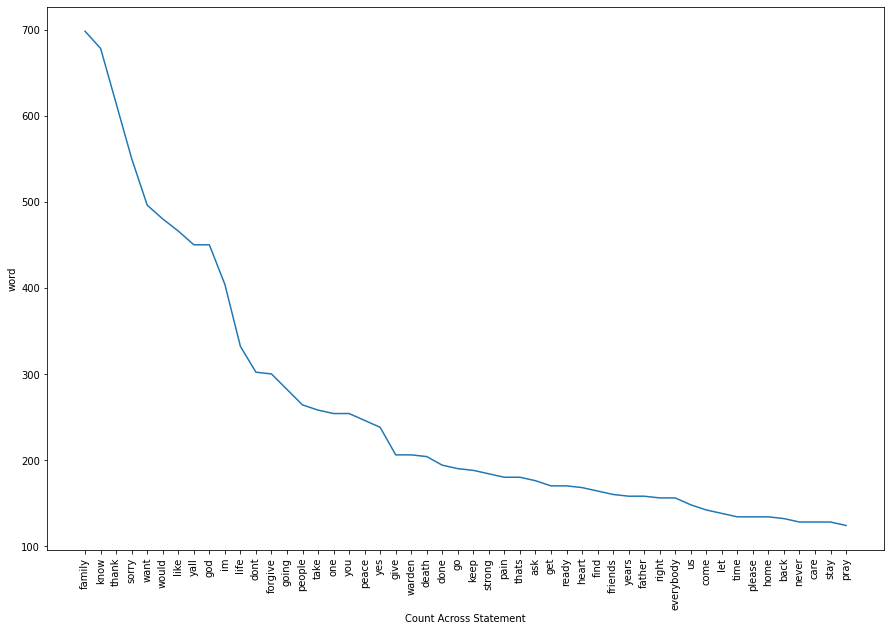

In [ ]:
fig, ax = plt.subplots(figsize = (15, 10))
plt.xticks(rotation = 90)
plt.xlabel("Count Across Statement")
plt.ylabel('word')
word_sum_cv = term_document_matrix.sum(axis = 0).sort_values(ascending = False)
plt.plot(word_sum_cv[0:50])

**My corpus's distribution somewhat follows Zipf's law, there appears to be some discrepancies in the line as it is not as smooth as the one in recitation. However, not everything in the data is perfect all the time. We discovered that the most common word in these individuals' final statements is 'family'**

**Even after removing commonly used words (ie stopwords) we still see that Zipf's law holds in that few words are used most often in a given context.**

## Most frequent words

**1. Family: It appears that most statements emphasize the importance of the individual's family. Whether it be how sorry they are or how much they love them**<br>
**2. Sorry: Who are these individuals apologetic to and how sorry are they?**<br>
**3. God: I am personally perplexed that God showed up so often, I'm curious to see if it used in more negative or positive sentiment.** <br>
**4. Forgive: I didn't know what to expect from this dataset, but I didn't expect individuals to ask for forgiveness. I suppose the media paints individuals on death row as heartless people who have 0 regrets for what they did**<br>
**5. Thank: This words showed up with high frequency given the plot above**<br> 

## KWIC Plots

**Hypothesis: the world "family" is used most ofen with "positive" words like "my", "love", and perhaps a word that is in relation to the victim's family such as "their"**

In [ ]:
tokenizer = nltk.WhitespaceTokenizer()

for i in range(0, len(df.LastStatement)):
  t = Text(tokenizer.tokenize(df.LastStatement[i]))
  t.concordance('family')

Displaying 1 of 1 matches:
                                    family for believing in me and being there
No matches
No matches
Displaying 1 of 1 matches:
                                    family i love yall tell kate i love her to
Displaying 6 of 6 matches:
                                    family i never wanted to kill your family 
                                    family or these people i am sorry for the 
blame nobody i got my mother and my family too i was forced i tell you from my
ly, i love you, be strong they have family too the way they suffer is the way 
, please go and try and talk to the family i love my family i understand why i
ry and talk to the family i love my family i understand why i am paying this p
No matches
No matches
No matches
No matches
No matches
Displaying 2 of 2 matches:
                                    family i have been trying to tell you for 
 i am sorry i know that i hurt your family bad i am sorry wynona should not of
No matches
No matches
No 

**It appears that the select words and other related ones were prevalent and used in context with the word "family". I reached this conclusion by scanning the documents and seeing how close they appear to be with the key word**

(h) We're going to do the same exercise for lexical dispersion plots. Again, they're pretty low-tech as NLP goes, but depending on your corpus could yield interesting insights. Generate one hypothesis about your corpus that you can test with a lexical dispersion plot(s).

## Dispersion Plots

**Hypothesis: The word 'love' will show up more frequently and in different parts of the sentence for the first cell**

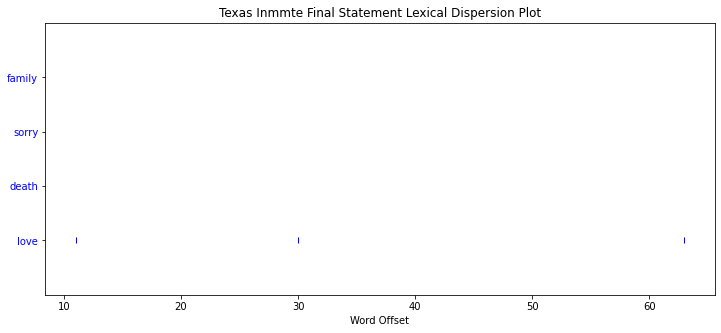

In [ ]:
fix, ax = plt.subplots(figsize = (12, 5))
targets = ['family', 'sorry', 'death', 'love']

tok_doc = tokenizer.tokenize(df.LastStatement[1])
dispersion_plot(tok_doc, targets, ignore_case = True, title='Texas Inmmte Final Statement Lexical Dispersion Plot')


**The hypothesis held up. As shown in the plot, based on the first cell, the word 'love' shows up at the beginning middle and end of the sentence**

## Comparing documents: similarity

**As each document is a statement from an individual, it is hard to say "this source is more similar to this source" as we did in Lab. However, we can look at the lengths of each document and compare them. Those documents with similar lengths will be more similar to each other**

**Make a column that takes the original length of the document**

In [ ]:
df['document_length'] = df['LastStatement'].apply(lambda x: len(x.split()))
df['document_length'].head(5)

0      139
1       84
10     109
100     30
101    229
Name: document_length, dtype: int64

**Let's actually see if there's a relationship between the original document length vs. the tokenized version**

In [ ]:
df['token_length'] = df['tokenized_filtered'].apply(lambda x: len(x.split()))
df['token_length'].head(5)

0      50
1      47
10     45
100    15
101    83
Name: token_length, dtype: int64

Text(0.5, 1.0, 'Original Document Length vs. Tokenized Document Length')

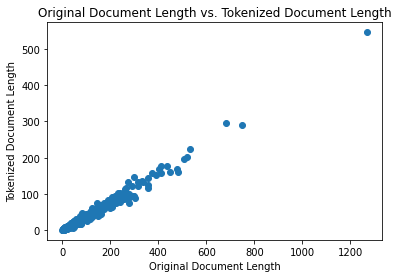

In [ ]:
plt.scatter(df.document_length, df.token_length)
plt.xlabel("Original Document Length")
plt.ylabel("Tokenized Document Length")
plt.title("Original Document Length vs. Tokenized Document Length")

**It looks like both lengths are roughly the same so we should be safe to use the tokenized length**

### Evaluating the cosine similarity between the documents above

**Create new dataframe and order longer documents first**

In [ ]:
#sort dataframe by the token length in descending order
df = df.sort_values(by = 'token_length', ascending = False)
df

,tokenized_filtered,Execution,LastName,FirstName,TDCJNumber,Age,Race,CountyOfConviction,AgeWhenReceived,EducationLevel,NativeCounty,PreviousCrime,Codefendants,NumberVictim,WhiteVictim,HispanicVictim,BlackVictim,VictimOther Races,FemaleVictim,MaleVictim,LastStatement,LastStatement_cleaned,tokenized,tokenized_unlisted,document_length,token_length
323,would like kill im innocent black murdered lyn...,222,Graham,Gary,696,39,Black,Harris,38.0,9.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,i would like to say that i did not kill bobby ...,would like kill bobby lambert im innocent blac...,"[would, like, kill, bobby, lambert, im, innoce...",would like kill bobby lambert im innocent blac...,1268,546
348,want start acknowledging ive family world bett...,197,Beathard,James,785,42,White,Trinity,28.0,15.0,1.0,0.0,1.0,3.0,3.0,0.0,0.0,0.0,1.0,2.0,i want to start out by acknowledging the love ...,want start acknowledging love ive family man w...,"[want, start, acknowledging, love, ive, family...",want start acknowledging love ive family man w...,684,295
285,spoken yes last full released way right want s...,260,"Hafdahl, Sr.",Randall,826,48,White,Randall,32.0,10.0,0.0,0.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,"spoken yes, i do my last full statement is bei...",spoken yes last full released way right want s...,"[spoken, yes, last, full, released, way, right...",spoken yes last full released way right want s...,747,290
331,written following personal l mcbride beatitude...,214,McBride,Michael,903,38,White,Lubbock,26.0,12.0,1.0,0.0,0.0,2.0,2.0,0.0,0.0,0.0,1.0,1.0,written the following is the personal final st...,written following personal michael l mcbride b...,"[written, following, personal, michael, l, mcb...",written following personal michael l mcbride b...,533,224
324,verbal written press released soon also respon...,221,Nuncio,Paul,999158,32,Hispanic,Hale,26.0,NaN,NaN,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,verbal i have a written statement for the pres...,verbal written press released soon also respon...,"[verbal, written, press, released, soon, also,...",verbal written press released soon also respon...,520,201
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
304,goodbye,241,Goodwin,Alvin,879,37,White,Montgomery,23.0,10.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,goodbye,goodbye,[goodbye],goodbye,1,1
436,mama,109,Barefield,John,844,32,Black,Harris,22.0,8.0,1.0,1.0,2.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,tell mama i love her,tell mama love,"[tell, mama, love]",tell mama love,5,1
462,ill,83,Bridge,Warren,668,34,White,Galveston,20.0,11.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,0.0,1.0,ill see you,ill see,"[ill, see]",ill see,3,1
463,nan,82,Williams,Walter,722,32,Black,Bexar,20.0,12.0,0.0,0.0,1.0,1.0,NaN,NaN,NaN,NaN,0.0,1.0,,,[],,0,1


**Create DTM with this new order, we have to keep in mind that earlier documents (ie: doc_1, doc_2) are longer than later ones (ie: doc_400, doc_401)**

In [ ]:
tfvec = TfidfVectorizer(stop_words = 'english', min_df = 0.3)
tf_idf = tfvec.fit_transform(df.tokenized_filtered)
feats = tfvec.get_feature_names()

tf_idf_array = tf_idf.toarray()
tf_idf_df = pd.DataFrame(tf_idf_array, columns = feats)
tf_idf_df = pd.DataFrame(tf_idf.toarray().transpose(), index = tfvec.get_feature_names()).T
tf_idf_df

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,family,god,know,like,sorry,thank,want
0,0.211057,0.000000,0.820537,0.128617,0.000000,0.120912,0.501010
1,0.483103,0.000000,0.268312,0.588800,0.000000,0.138382,0.573398
2,0.470775,0.195876,0.522930,0.000000,0.191903,0.539404,0.372511
3,0.000000,0.662421,0.294744,0.323402,0.000000,0.608059,0.000000
4,0.288012,0.539251,0.479880,0.000000,0.528315,0.000000,0.341844
...,...,...,...,...,...,...,...
425,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
426,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
427,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
428,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


Text(0.5, 1.0, 'Cosine Similarity between Documents within Corpus')

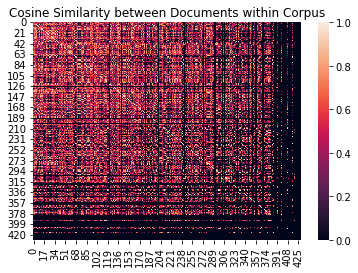

In [ ]:
pairwise_sim = cosine_similarity(tf_idf)

ax = plt.axes()
sns.heatmap(data = pd.DataFrame(pairwise_sim, columns = tf_idf_df.index, index = tf_idf_df.index),
           ax = ax)
ax.set_title("Cosine Similarity between Documents within Corpus")

(c) How did your hypothesis hold up? Briefly explain your assessment.

**Yes, it appears the hypothesis held up! As you can see by the black coloring towards the right and bottom edges of the heatmap, it shows that longer documents are less similar to shorter documents and vice versa**

**Euclidean Distance**

Text(0.5, 1.0, 'Euclidean Distances between Documents within Corpus')

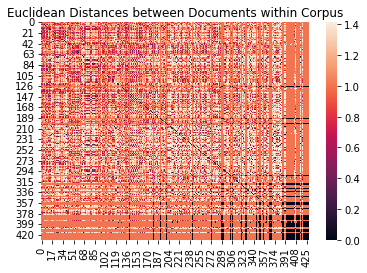

In [ ]:
pairwise_sim2 = euclidean_distances(tf_idf)
ax = plt.axes()
sns.heatmap(data = pd.DataFrame(pairwise_sim2, columns = tf_idf_df.index, index = tf_idf_df.index), ax = ax)
ax.set_title('Euclidean Distances between Documents within Corpus')



**The hypothesis appears to hold up with the euclidean distance as well! Higher euclidean distances means the more different documents are (the opposite of the cosine similarity method). As shown on the heatmap, the right and bottom edges are darker, or have higher values. This is the same image displayed in the plot above.**

**The cosine similarity metric is more appropriate for this corpus than the Euclidean distance. This is because the Euclidean distance is influenced by the number of terms. The number of terms had more of an effect on Euclidean distance than it does on cosine similarity and when ur doing short vs long tweets u don’t want number of terms to have as big of an impact**

**I was surprised that both the euclidean distance and cosine similarity had essentially the same answer given the differences in the calculations, especially the accountance of amount of words in the euclidean distance**

## 5. Comparing documents: diversity & complexity

**Lexical diversity is the measure of how many different "things" are in a corpus. Meaning, the variety of different words used in one documents vs. another. Within lexical diversity is also the measurement of Lexican Sophistication, the use of words that are not among the most frequent in a language, as well as Lexican richness, the wealth of words at an author's or speaker's command. Lexican diversity is rather difficult to measure because in NLP, we use complex adaptive systems, which are networks of diverse agents whose interactions give rise to emergent outcomes. Other fields, such as ecology, language, culture, and economics have also tried to study "diversity" however it's ambiguous because there are too many factors to consider and assign weights of importance to. Ultimately, each distinct part of "diversity" requires different types of analyses based on what level the language is or what types of writing is being analyzed**

**Lexical diversity is important as it tells how how "skilled"* the speaker is in using a langauge**<br>
***skilled is rather elitist**

**Linguistic complexity assesses the amount of parts and interactions there are in language. Moreover, it refers to complexity amongst languages (ie: are some more complex than others?). Furthermore, in studying linguistic complexity, we seek to see how "readable" a document is**

**We may want to measure the complexity of a document or corpus to see how hard it is to describe or create a piece of text**

**Hypotheisis: Longer documents have more lexical diversity than shorter documents**

In [ ]:
#TTR
def TTR(tokenized_document):
    total_types = Counter(tokenized_document)
    total_tokens = len(tokenized_document)
    TTR = len(total_types)/total_tokens
    return TTR

#R
def R(tokenized_document):
    total_types = Counter(tokenized_document)
    total_tokens = len(tokenized_document)
    R = len(total_types) / np.sqrt(total_tokens) 
    
    return R

In [ ]:
df['TTR'] = df.tokenized_filtered.apply(lambda x: TTR(x))
df['R'] = df.tokenized_filtered.apply(lambda x: R(x))

**To look at the relationships between length and the different scores, I will plot side-by-side plots, one for each score (TTR and R)**

Text(0, 0.5, 'Token Length')

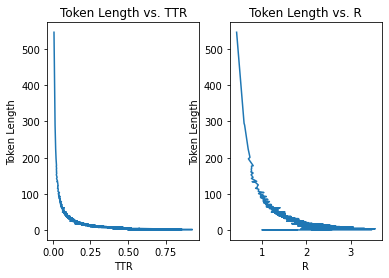

In [ ]:
#plot TTR vs. Token Length
plt.subplot(1, 2, 1)
plt.plot(df.TTR, df.token_length)
plt.title("Token Length vs. TTR")
plt.xlabel("TTR")
plt.ylabel("Token Length")

#plot R vs. Token Length
plt.subplot(1, 2, 2)
plt.plot(df.R, df.token_length)
plt.title("Token Length vs. R")
plt.xlabel("R")
plt.ylabel("Token Length")


In [ ]:
df.head()

,tokenized_filtered,Execution,LastName,FirstName,TDCJNumber,Age,Race,CountyOfConviction,AgeWhenReceived,EducationLevel,NativeCounty,PreviousCrime,Codefendants,NumberVictim,WhiteVictim,HispanicVictim,BlackVictim,VictimOther Races,FemaleVictim,MaleVictim,LastStatement,LastStatement_cleaned,tokenized,tokenized_unlisted,document_length,token_length,TTR,R
323,would like kill im innocent black murdered lyn...,222,Graham,Gary,696,39,Black,Harris,38.0,9.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,i would like to say that i did not kill bobby ...,would like kill bobby lambert im innocent blac...,"[would, like, kill, bobby, lambert, im, innoce...",would like kill bobby lambert im innocent blac...,1268,546,0.006908,0.423788
348,want start acknowledging ive family world bett...,197,Beathard,James,785,42,White,Trinity,28.0,15.0,1.0,0.0,1.0,3.0,3.0,0.0,0.0,0.0,1.0,2.0,i want to start out by acknowledging the love ...,want start acknowledging love ive family man w...,"[want, start, acknowledging, love, ive, family...",want start acknowledging love ive family man w...,684,295,0.013478,0.591980
285,spoken yes last full released way right want s...,260,"Hafdahl, Sr.",Randall,826,48,White,Randall,32.0,10.0,0.0,0.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,"spoken yes, i do my last full statement is bei...",spoken yes last full released way right want s...,"[spoken, yes, last, full, released, way, right...",spoken yes last full released way right want s...,747,290,0.014054,0.604488
331,written following personal l mcbride beatitude...,214,McBride,Michael,903,38,White,Lubbock,26.0,12.0,1.0,0.0,0.0,2.0,2.0,0.0,0.0,0.0,1.0,1.0,written the following is the personal final st...,written following personal michael l mcbride b...,"[written, following, personal, michael, l, mcb...",written following personal michael l mcbride b...,533,224,0.018031,0.684685
324,verbal written press released soon also respon...,221,Nuncio,Paul,999158,32,Hispanic,Hale,26.0,NaN,NaN,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,verbal i have a written statement for the pres...,verbal written press released soon also respon...,"[verbal, written, press, released, soon, also,...",verbal written press released soon also respon...,520,201,0.020233,0.725307


**As shown by the plots above, texts with higher numbers of tokens have actually lower lexical variation (indicated by the left tail of the plots that shows higher token lengths and a lower TTR/R)**

**Lexical Copmlexity Hypothesis: Tokens that have shorter lengths are more readable. With the Felsch Reading Ease Score we can test these hypotheses**

In [ ]:
df['detokenized'] = df.tokenized_filtered.apply(lambda x: TreebankWordDetokenizer().detokenize(x))
df['flesch_reading_ease_score'] = df.detokenized.apply(lambda x: textstat.flesch_reading_ease(x))

(k) How did your hypothesis do? Briefly explain your assessment.

**In order to assess this, I will plot the relationship between token length and the Flesch Reading Ease Score**

Text(0.5, 0, 'Token Length')

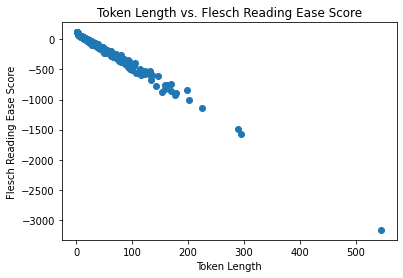

In [ ]:
#plot TTR vs. Token Length
plt.scatter(df.token_length, df.flesch_reading_ease_score)
plt.title("Token Length vs. Flesch Reading Ease Score")
plt.ylabel("Flesch Reading Ease Score")
plt.xlabel("Token Length")

**As shown above, there seems to be a strong, negative, linear relationship between Token Length and the Flesch Reading Ease Score meaning that the less tokens the more readable the text is**

## Sentiment analysis

**I want to use a classifier to perform the sentiment analysis, specifically a pre-trained sentiment analysis model. The reason as to why I am not training my own is because there really isn't a readily available training dataset for negative and postive sentiment regarding someone's final statement.**

**Hypothesis: Longer statements have a more positive sentiment. I suspect that longer statements are more apologetic and expressive towards the individual's loved ones.**

In [ ]:
df['blobs'] = df.LastStatement.map(lambda s: textblob.TextBlob(s))
df['polarity'] = df.blobs.map(lambda b: b.sentiment[0])

**Now that we've calculated the polarity using the textblob library, let's plot the relationship between document length and polarity**

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Correlation Between Document Length and Polarity:  -0.09


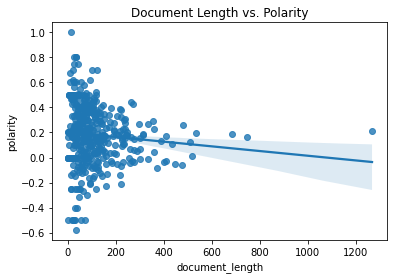

In [ ]:
#calculate best fit line
sns.regplot(df.document_length, df.polarity).set(title = 'Document Length vs. Polarity')
print("Correlation Between Document Length and Polarity: ", str(round(df.document_length.corr(df.polarity), 2)))
# plt.scatter(df.document_length, df.polarity)
# plt.xlabel("Original Document Length")
# plt.ylabel("Polairty")
# plt.title("Document Length vs. Polarity")

**It appears there's not really much of a relationship between document length and sentiment. Therefore, I reject my hypothesis that longer documents have a more positive sentiment**

## Summary

**Overall I was able to learn the relationships bewteen how much an individual says as well as the overall sentiment. I want to continue with this research in the hopes of "humanizing" such individuals. In my personal experience, it seems that the American media dehumanizes, or even demonizes people on death row as ruthless. Though their acts may have be heinous, no one is "naturally" bad. People need help and everyone deserves access to resources that can assist the with whatever struggles they face, which may prevent the violent crimes committed. Moreover, it'd be nice to gain exposure to those who were truly falsely convicted.**